<h1 dir=rtl align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
کمک به بحران برق
</font>
</h1>

<h2 dir=rtl align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
مقدمه و صورت مسئله
</font>
</h2>


<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir">
در این سوال از مسابقه با داده های جمع آوری شده از سنسورهای توربین های بادی سر و کار داریم. با توجه به توضیحات ذکر شده در صفحه سوال داده ها را دانلود کرده و به حل مسئله بپردازید:)
</font>
</p>

<h2 dir=rtl align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
معرفی مجموعه داده
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
با استفاده از <a href="https://drive.google.com/file/d/162iKuz9w5vuFkG8vbXuTiFswthvL1qZT/view?usp=sharing">لینک</a> میتوانید به مجموعه داده های آموزش و آزمایش دسترسی داشته باشید و آنها را دانلود کنید.
</font> 
</p>


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Training Set
- **train_operational_data.csv**: Full time-series sensor readings for each turbine.
- **train_specifications.csv**: Static technical specifications of turbine components.
- **train_tte.csv**: Turbine lifetime and failure status (used as targets).

### Validation Set
- **validation_operational_data.csv**: Truncated operational histories for realistic prediction simulation.
- **validation_specifications.csv**: Technical specifications of validation turbines.
- **validation_labels.csv**: True class labels (0–4) for validation turbines.

### Test Set
- **test_operational_data.csv**: Truncated operational histories for unseen turbines.
- **test_specifications.csv**: Technical specifications of test turbines.



In [4]:
# train data
df_tr_tte = pd.read_csv("Data/train_tte.csv")# train_tte.csv: Lifetime + failure labels (targets)
df_tr_op = pd.read_csv("Data/train_operational_readouts.csv")# train_operational_data.csv: Full sensor time-series per turbine
df_tr_spec = pd.read_csv("Data/train_specifications.csv")# train_specifications.csv: Static technical specs per turbine

# validation data
df_val_lbl = pd.read_csv("Data/validation_labels.csv")# validation_labels.csv: True class labels for validation set
df_val_op = pd.read_csv("Data/validation_operational_readouts.csv")# validation_operational_data.csv: Truncated sensor histories for validation
df_val_spec = pd.read_csv("Data/validation_specifications.csv")# validation_specifications.csv: Specs for validation turbines

# test data
df_ts_op = pd.read_csv("Data/test_operational_readouts.csv")# test_operational_data.csv: Truncated sensor histories for test turbines
df_ts_spec = pd.read_csv("Data/test_specifications.csv")# test_specifications.csv: Specs for test turbines


In [7]:
df_val_spec

,vehicle_id,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7
0,10,Cat0,Cat0,Cat0,Cat0,Cat0,Cat1,Cat0,Cat1
1,16,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat1
2,18,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat1
3,23,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat0
4,45,Cat0,Cat0,Cat0,Cat0,Cat0,Cat1,Cat0,Cat1
...,...,...,...,...,...,...,...,...,...
5041,33596,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat7
5042,33601,Cat0,Cat1,Cat1,Cat0,Cat0,Cat0,Cat1,Cat4
5043,33605,Cat0,Cat1,Cat1,Cat0,Cat0,Cat0,Cat0,Cat4
5044,33612,Cat0,Cat1,Cat1,Cat0,Cat0,Cat0,Cat1,Cat4


In [8]:
df_tr_merged = df_tr_op.merge(df_tr_tte, on="vehicle_id", how="left")
df_val_merged = df_val_op.merge(df_val_lbl, on="vehicle_id", how="left")

df_tr_merged["in_study_repair"].value_counts()

in_study_repair
0    1016600
1     105852
Name: count, dtype: int64

In [ ]:
df_tr_merged["RUL"] = np.where(
    df_tr_merged["in_study_repair"] == 1,
    df_tr_merged["length_of_study_time_step"] - df_tr_merged["time_step"],
    np.inf
)

df_tr_merged["RUL"] = df_tr_merged["RUL"].clip(lower=0)


def rul_to_class(rul):
    if rul > 48:
        return 0
    elif 24 < rul <= 48:
        return 1
    elif 12 < rul <= 24:
        return 2
    elif 6 < rul <= 12:
        return 3
    else:  # 0 <= rul <= 6
        return 4

df_tr_merged["class_label"] = df_tr_merged["RUL"].apply(rul_to_class)

print("Labels created successfully.")
print(df_val_merged["class_label"].value_counts())


Labels created successfully.
class_label
0    1096712
1      12503
2       6179
4       3858
3       3200
Name: count, dtype: int64


In [10]:
print(df_val_merged["class_label"].value_counts())


class_label
0    191150
4      2997
3       948
2       600
1       532
Name: count, dtype: int64


In [13]:
df_tr_merged

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_30,397_31,397_32,397_33,397_34,397_35,length_of_study_time_step,in_study_repair,RUL,class_label
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,...,784.0,150228.0,261904.0,93172.0,17874.0,452.0,510.0,0,inf,0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,...,784.0,150228.0,261905.0,93172.0,17874.0,452.0,510.0,0,inf,0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,NaN,NaN,NaN,NaN,...,1420.0,204832.0,313485.0,106464.0,19306.0,452.0,510.0,0,inf,0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,NaN,NaN,NaN,NaN,...,1444.0,211688.0,318901.0,107745.0,19406.0,453.0,510.0,0,inf,0
4,0,21.0,365550.0,15295.0,14966985.0,2720.0,NaN,NaN,NaN,NaN,...,1445.0,213956.0,323997.0,109514.0,19535.0,454.0,510.0,0,inf,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122447,33643,101.0,2136810.0,41412.0,81068654.0,10365.0,843.0,6408272.0,10964376.0,6092347.0,...,19500.0,612343.0,626033.0,100155.0,17033.0,24.0,130.2,0,inf,0
1122448,33643,107.0,2283285.0,44660.0,86639835.0,12317.0,843.0,6596477.0,12358026.0,6721702.0,...,20484.0,652688.0,670517.0,107367.0,18901.0,24.0,130.2,0,inf,0
1122449,33643,113.8,2462865.0,48370.0,93439419.0,13910.0,843.0,6669542.0,12830421.0,7415497.0,...,21688.0,698824.0,722453.0,115851.0,21237.0,28.0,130.2,0,inf,0
1122450,33643,119.8,2627250.0,51101.0,99682931.0,14854.0,843.0,7074468.0,13604706.0,7747492.0,...,22732.0,757856.0,777630.0,123155.0,22357.0,32.0,130.2,0,inf,0


In [14]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def build_last_windows(
    df_op,
    window_size=128,
    feature_cols=None,
    pad_value=np.nan,
    return_mask=True,
    return_labels=True,
    sort_time_col="time_step",
    label_col="class_label"
):

    non_feat = {"vehicle_id", sort_time_col, "length_of_study_time_step", "in_study_repair", "RUL", label_col}

    if feature_cols is None:
        feature_cols = [c for c, dtype in df_op.dtypes.items()
                        if c not in non_feat and (pd.api.types.is_numeric_dtype(dtype))]
        feature_cols = sorted(feature_cols)

    vehicle_ids = df_op["vehicle_id"].unique()
    n_veh = len(vehicle_ids)
    n_feat = len(feature_cols)

    X = np.full((n_veh, window_size, n_feat), pad_value, dtype=np.float32)
    mask = np.zeros((n_veh, window_size), dtype=bool) if return_mask else None
    labels = np.full((n_veh,), -1, dtype=np.int64) if return_labels else None

    grouped = df_op.groupby("vehicle_id", sort=False)

    for i, vid in enumerate(tqdm(vehicle_ids, desc="building windows")):
        g = grouped.get_group(vid)
        if g[sort_time_col].is_monotonic_increasing:
            g_sorted = g
        else:
            g_sorted = g.sort_values(sort_time_col)

        arr = g_sorted[feature_cols].to_numpy(dtype=np.float32, copy=False)
        L = arr.shape[0]
        if L == 0:
            continue

        if L >= window_size:
            last = arr[-window_size:, :]
            start_idx = 0
            valid_len = window_size
            X[i, :, :] = last
            if mask is not None:
                mask[i, :] = True
        else:
            last = arr
            valid_len = L
            X[i, window_size - L:, :] = last
            if mask is not None:
                mask[i, window_size - L:] = True

        if return_labels:
            if label_col in g_sorted.columns:
                labels[i] = int(g_sorted[label_col].iloc[-1])
            else:
                labels[i] = -1

    return {
        "vehicle_ids": vehicle_ids,
        "X": X,
        "mask": mask,
        "labels": labels,
        "feature_cols": feature_cols
    }


WINDOW = 128

out = build_last_windows(df_tr_merged, window_size=WINDOW, pad_value=np.nan)

vehicle_ids = out["vehicle_ids"]
X = out["X"]
mask = out["mask"]
labels = out["labels"]

print("n_vehicles:", len(vehicle_ids))
print("X.shape:", X.shape)
print("mask.shape:", None if mask is None else mask.shape)
print("labels unique:", np.unique(labels)[:10])

building windows: 100%|██████████| 23550/23550 [00:29<00:00, 788.04it/s] 

n_vehicles: 23550
X.shape: (23550, 128, 105)
mask.shape: (23550, 128)
labels unique: [0 1 2 3 4]


In [15]:
out = build_last_windows(df_val_merged, window_size=WINDOW, pad_value=np.nan)

vehicle_ids_val = out["vehicle_ids"]
X_val = out["X"]
mask_val = out["mask"]
labels_val = out["labels"]

print("n_vehicles:", len(vehicle_ids_val))
print("X.shape:", X_val.shape)
print("mask.shape:", None if mask is None else mask_val.shape)
print("labels unique:", np.unique(labels_val)[:10])

building windows: 100%|██████████| 5046/5046 [00:05<00:00, 982.26it/s] 

n_vehicles: 5046
X.shape: (5046, 128, 105)
mask.shape: (5046, 128)
labels unique: [0 1 2 3 4]


In [18]:
out = build_last_windows(df_ts_op, window_size=WINDOW, pad_value=np.nan)

vehicle_ids_test = out["vehicle_ids"]
X_test = out["X"]
mask_test = out["mask"]
labels_test = out["labels"]

print("n_vehicles:", len(vehicle_ids_test))
print("X.shape:", X_test.shape)
print("mask.shape:", None if mask is None else mask_test.shape)
print("labels unique:", np.unique(labels_test)[:10])

building windows: 100%|██████████| 5045/5045 [00:03<00:00, 1557.11it/s]

n_vehicles: 5045
X.shape: (5045, 128, 105)
mask.shape: (5045, 128)
labels unique: [-1]


In [19]:
import numpy as np
from collections import Counter

def oversample_keep_size(X, labels):
    rng = np.random.default_rng(42)
    
    class_counts = Counter(labels)
    print("Before balancing:", class_counts)
    
    total_n = len(labels)
    n_classes = len(class_counts)
    
    target_per_class = total_n // n_classes
    
    indices = []
    
    for cls in sorted(class_counts.keys()):
        cls_idx = np.where(labels == cls)[0]
        
        if len(cls_idx) < target_per_class:
            selected = rng.choice(cls_idx, target_per_class, replace=True)
        else:
            selected = cls_idx
        
        indices.append(selected)

    indices = np.concatenate(indices)
    
    if len(indices) > total_n:
        indices = rng.choice(indices, total_n, replace=False)

    rng.shuffle(indices)

    X_bal = X[indices]
    y_bal = labels[indices]

    print("After balancing:", Counter(y_bal))
    print("New shape:", X_bal.shape)
    
    return X_bal, y_bal


X_bal, y_bal = oversample_keep_size(X, labels)

Before balancing: Counter({0: 21288, 4: 2000, 3: 161, 2: 70, 1: 31})
After balancing: Counter({0: 12445, 4: 2820, 1: 2792, 2: 2776, 3: 2717})
New shape: (23550, 128, 105)


In [20]:
from sklearn.impute import SimpleImputer

n_samples = X.shape[0]
window = X.shape[1]
n_feat = X.shape[2]

# Flatten
X_flat = X.reshape(n_samples, window * n_feat)

if mask is None:
    valid_counts = np.full((n_samples,1), window, dtype=np.float32)
else:
    valid_counts = mask.sum(axis=1).reshape(-1,1).astype(np.float32)

X_flat = np.hstack([X_flat, valid_counts])

print("X_flat shape before impute:", X_flat.shape)

imputer = SimpleImputer(strategy="median")
X_flat_imputed = imputer.fit_transform(X_flat)

print("X_flat_imputed shape:", X_flat_imputed.shape)
print("NaNs after impute:", np.isnan(X_flat_imputed).sum())

X_flat shape before impute: (23550, 13441)
X_flat_imputed shape: (23550, 13441)
NaNs after impute: 0


In [22]:
n_samples_val = X_val.shape[0]
window_val = X_val.shape[1]
n_feat_val = X_val.shape[2]

# Flatten
X_flat_val = X_val.reshape(n_samples_val, window_val * n_feat_val)

if mask is None:
    valid_counts = np.full((n_samples_val,1), window_val, dtype=np.float32)
else:
    valid_counts = mask_val.sum(axis=1).reshape(-1,1).astype(np.float32)

X_flat_val = np.hstack([X_flat_val, valid_counts])

print("X_flat_val shape before impute:", X_flat_val.shape)

imputer = SimpleImputer(strategy="median")
X_flat_val_imputed = imputer.fit_transform(X_flat_val)

print("X_flat_imputed shape:", X_flat_val_imputed.shape)
print("NaNs after impute:", np.isnan(X_flat_val_imputed).sum())

X_flat_val shape before impute: (5046, 13441)
X_flat_imputed shape: (5046, 13441)
NaNs after impute: 0


In [ ]:
n_samples_test = X_test.shape[0]
window_test = X_test.shape[1]
n_feat_test = X_test.shape[2]

# Flatten
X_flat_test = X_test.reshape(n_samples_test, window_test * n_feat_test)

if mask is None:
    valid_counts = np.full((n_samples_test,1), window_test, dtype=np.float32)
else:
    valid_counts = mask_test.sum(axis=1).reshape(-1,1).astype(np.float32)

X_flat_test = np.hstack([X_flat_test, valid_counts])

print("X_flat_test shape before impute:", X_flat_test.shape)

imputer = SimpleImputer(strategy="median")
X_flat_test_imputed = imputer.fit_transform(X_flat_test)

print("X_flat_imputed shape:", X_flat_test_imputed.shape)
print("NaNs after impute:", np.isnan(X_flat_test_imputed).sum())

X_flat_test shape before impute: (5045, 13441)
X_flat_imputed shape: (5045, 13441)
NaNs after impute: 0


In [26]:
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb

classes = np.unique(labels)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
class_weight = {int(c): float(w) for c,w in zip(classes, cw)}
print("Computed class_weight:", class_weight)

model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(classes),
    n_estimators=2000,
    learning_rate=0.05,
    random_state=42,
    class_weight=class_weight,
    n_jobs=-1
)

Computed class_weight: {0: 0.22125140924464487, 1: 151.93548387096774, 2: 67.28571428571429, 3: 29.25465838509317, 4: 2.355}


In [27]:
import lightgbm as lgb
from tqdm.auto import tqdm

n_estimators = model.get_params()['n_estimators']

pbar = tqdm(total=n_estimators)

def tqdm_callback(env):
    pbar.update(1)

eval_set = [(X_flat_imputed, labels), (X_flat_val_imputed, labels_val)]

model.fit(
    X_flat_imputed, labels,
    eval_set=eval_set,
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50),
        tqdm_callback
    ]
)

pbar.close()

print("Best iteration:", model.best_iteration_)

  0%|          | 0/2000 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 7.438757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3305140
[LightGBM] [Info] Number of data points in the train set: 23550, number of used features: 13361
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 0.28307	valid_1's multi_logloss: 0.714675
[100]	training's multi_logloss: 0.151331	valid_1's multi_logloss: 0.390457
[150]	training's multi_logloss: 0.104023	valid_1's multi_logloss: 0.267664
[200]	training's multi_logloss: 0.0776755	valid_1's multi_logloss: 0.222408
[250]	training's multi_logloss: 0.059636	valid_1's multi_logloss: 0.218172


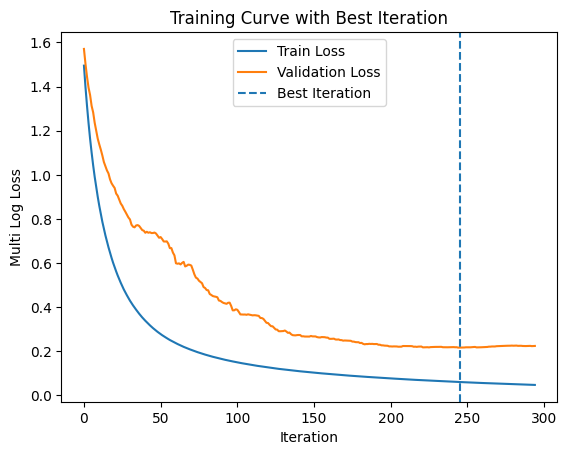

In [28]:
import matplotlib.pyplot as plt

results = model.evals_result_

train_loss = results['training']['multi_logloss']
val_loss   = results['valid_1']['multi_logloss']
best_iter = model.best_iteration_


plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(best_iter, linestyle='--', label='Best Iteration')
plt.xlabel('Iteration')
plt.ylabel('Multi Log Loss')
plt.title('Training Curve with Best Iteration')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

probs = model.predict_proba(X_flat_val_imputed)

pred_argmax = np.argmax(probs, axis=1)

R = np.array([
    [  2.5,  -2.0,  -4.0,  -8.0, -12.0],
    [ -15.0, 20.0,  -3.0,  -6.0, -10.0],
    [ -30.0, -15.0, 40.0,  -5.0,  -8.0],
    [ -50.0, -30.0, -15.0, 80.0,  -5.0],
    [ -80.0, -50.0, -30.0, -15.0, 150.0],
], dtype=float)


expected_rewards = probs.dot(R)
pred_cost_sensitive = np.argmax(expected_rewards, axis=1)

print("Argmax preds distribution:", Counter(pred_argmax))
print("Cost-sensitive preds distribution:", Counter(pred_cost_sensitive))

c:\Users\taha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Argmax preds distribution: Counter({0: 5045, 4: 1})
Cost-sensitive preds distribution: Counter({0: 3294, 4: 1752})


In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

def evaluate_preds(y_true, y_pred, name="model"):
    print(f"===== Evaluation: {name} =====")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    print("Confusion Matrix:\n", cm)
    return cm

cm_argmax = evaluate_preds(labels_val, pred_argmax, name="Argmax")
cm_cost = evaluate_preds(labels_val, pred_cost_sensitive, name="Cost-sensitive decision")

# Raw score computation = sum_i R[true_i, pred_i]
raw_argmax = R[labels_val, pred_argmax].sum()
raw_cost = R[labels_val, pred_cost_sensitive].sum()
print("Raw score (argmax):", raw_argmax)
print("Raw score (cost-sensitive):", raw_cost)

# Maximum possible score = sum_i max_j R[true_i, j]
max_possible = np.maximum(R.max(axis=1), 0)  # but careful: R.max(axis=1) per actual class
# better: per-sample maximum using true label of each sample:
max_per_sample = np.array([R[true].max() for true in labels_val])
maximum_possible_score = max_per_sample.sum()

final_argmax = 100 * max(0, raw_argmax) / maximum_possible_score
final_cost = 100 * max(0, raw_cost) / maximum_possible_score
print("Maximum possible score (on this val set):", maximum_possible_score)
print("Final Score (argmax): {:.4f}".format(final_argmax))
print("Final Score (cost-sensitive): {:.4f}".format(final_cost))

===== Evaluation: Argmax =====
Accuracy: 0.972849782005549
Balanced Accuracy: 0.199959266802444
              precision    recall  f1-score   support

           0     0.9730    0.9998    0.9862      4910
           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.0000    0.0000    0.0000        30
           4     0.0000    0.0000    0.0000        76

    accuracy                         0.9728      5046
   macro avg     0.1946    0.2000    0.1972      5046
weighted avg     0.9468    0.9728    0.9597      5046

Confusion Matrix:
 [[4909    0    0    0    1]
 [  16    0    0    0    0]
 [  14    0    0    0    0]
 [  30    0    0    0    0]
 [  76    0    0    0    0]]
===== Evaluation: Cost-sensitive decision =====
Accuracy: 0.6478398731668649
Balanced Accuracy: 0.23938149855289956
              precision    recall  f1-score   support

           0     0.9800    0.6574    0.7869      4910
           1     0.0000    0.0

c:\Users\taha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\taha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\taha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

<h2 dir=rtl align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
 پیش‌بینی برای داده تست و خروجی
</font>
</h2>

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    پیش‌بینی مدل خود بر روی داده‌های آزمایش (<code>test</code>) را در قالب یک <code>dataframe</code> در متغیری با نام <code>submission</code>ذخیره کنید.
</font>
</p>

<center>
<div dir=rtl style="direction: rtl;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    
|class_label|vehicle_id|
|---|---|
|?|1 |
    
</font>


In [32]:
probs = model.predict_proba(X_flat_test_imputed)
pred_argmax = np.argmax(probs, axis=1)

c:\Users\taha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [33]:
vehicle_id = df_ts_spec["vehicle_id"]

submission = pd.DataFrame({
    "vehicle_id": vehicle_id,
    "class_label": pred_argmax 
})

submission



,vehicle_id,class_label
0,1,0
1,6,0
2,7,0
3,9,0
4,11,0
...,...,...
5040,33617,0
5041,33619,0
5042,33632,0
5043,33634,0


<h2 dir=rtl align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
<b>سلول جواب‌ساز</b>
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
    برای ساخته‌شدن فایل <code>result.zip</code> سلول زیر را اجرا کنید. توجه داشته باشید که پیش از اجرای سلول زیر تغییرات اعمال شده در نت‌بوک را ذخیره کرده باشید (<code>ctrl+s</code>) در غیر این صورت، در پایان مسابقه نمره شما به صفر تغییر خواهد کرد.
    <br>
    همچنین اگر از کولب برای اجرای این فایل نوت‌بوک استفاده می‌کنید، قبل از ارسال فایل <code>result.zip</code>، آخرین نسخه‌ی نوت‌بوک خود را دانلود کرده و داخل فایل ارسالی قرار دهید.
</font>

In [34]:
import zipfile
import joblib
import os

if not os.path.exists(os.path.join(os.getcwd(), 'notebook.ipynb')):
    %notebook -e notebook.ipynb

def compress(file_names):
    print("File Paths:")
    print(file_names)
    compression = zipfile.ZIP_DEFLATED
    with zipfile.ZipFile("result.zip", mode="w") as zf:
        for file_name in file_names:
            zf.write('./' + file_name, file_name, compress_type=compression)

submission.to_csv('submission.csv', index=False)
file_names = ['notebook.ipynb', 'submission.csv']
compress(file_names)

File Paths:
['notebook.ipynb', 'submission.csv']
